In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

data = pd.read_csv('../data/nyc_taxi.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp',inplace=True)

print data.index.dtype,len(data)

# use 7 days to predict 1 day
PRE_DAYS = 4
ONE_DAY_DATA_LEN = 48
def make_data(X, pre_days=PRE_DAYS):
    xs = []
    ys = []
    data_len = len(X)/ONE_DAY_DATA_LEN
    print data_len
    for i in range(data_len-PRE_DAYS):
        start_idx = i*ONE_DAY_DATA_LEN
        x = X[start_idx:start_idx+pre_days*ONE_DAY_DATA_LEN]
        y = X[start_idx+pre_days*ONE_DAY_DATA_LEN:start_idx+(1+pre_days)*ONE_DAY_DATA_LEN]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

scaler = RobustScaler()
daily_data = scaler.fit_transform(data.values.flatten())
print daily_data.shape
x,y = make_data(daily_data)
print x.shape,y.shape

def split_train_test(x, y, n):
    x_train, x_test = x[0:-n], x[-n:]
    y_train, y_test = y[0:-n], y[-n:]
    return x_train, y_train, x_test, y_test

X_train, Y_train, X_test, Y_test = split_train_test(x, y, 30)
print X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

datetime64[ns] 10320
(10320,)
215
(211, 192) (211, 48)
(181, 192) (181, 48) (30, 192) (30, 48)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:965: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:987: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:965: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [7]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.regularizers import l2, activity_l2

INPUT_LEN = ONE_DAY_DATA_LEN * PRE_DAYS
OUTPUT_LEN = 48

model = Sequential()
model.add(Activation('relu', input_shape=(INPUT_LEN,)))
model.add(Dense(INPUT_LEN))
model.add(Activation('linear', input_shape=(INPUT_LEN,)))
model.add(Dense(INPUT_LEN/2, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.1))
model.add(Activation('linear', input_shape=(INPUT_LEN/2,)))
model.add(Dense(INPUT_LEN/4, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.1))
model.add(Activation('linear', input_shape=(INPUT_LEN/4,)))
model.add(Dense(OUTPUT_LEN))

model.compile(loss='mse', optimizer='rmsprop')

print 'compile done'

model.fit(X_train, Y_train, nb_epoch=100, verbose=1, batch_size=50, validation_data=(X_test, Y_test))

print 'fit done'

compile done
Train on 181 samples, validate on 30 samples
Epoch 1/50
181/181 [==============================] - 0s - loss: 2.6662 - val_loss: 0.4877
Epoch 2/50
181/181 [==============================] - 0s - loss: 2.2537 - val_loss: 0.4815
Epoch 3/50
181/181 [==============================] - 0s - loss: 2.1253 - val_loss: 0.4665
Epoch 4/50
181/181 [==============================] - 0s - loss: 2.0179 - val_loss: 0.4131
Epoch 5/50
181/181 [==============================] - 0s - loss: 1.9134 - val_loss: 0.4033
Epoch 6/50
181/181 [==============================] - 0s - loss: 1.8594 - val_loss: 0.3652
Epoch 7/50
181/181 [==============================] - 0s - loss: 1.7358 - val_loss: 0.3720
Epoch 8/50
181/181 [==============================] - 0s - loss: 1.6708 - val_loss: 0.3016
Epoch 9/50
181/181 [==============================] - 0s - loss: 1.5800 - val_loss: 0.2925
Epoch 10/50
181/181 [==============================] - 0s - loss: 1.5104 - val_loss: 0.2836
Epoch 11/50
181/181 [==========

## on test data set

0.739500359212
0.71626296619
2743.36839886 14400.3347222 7354.23979249


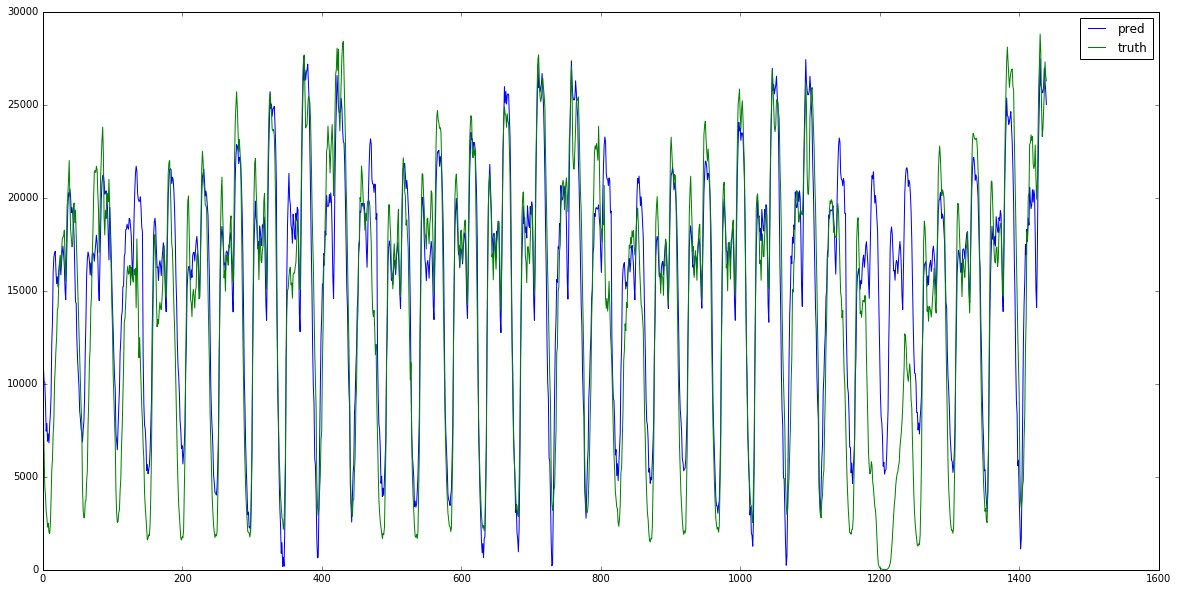

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred.reshape(-1,1))
truth = scaler.inverse_transform(Y_test.reshape(-1,1))

from sklearn import metrics

print metrics.explained_variance_score(truth,pred)
print metrics.r2_score(truth,pred)
print metrics.mean_absolute_error(truth,pred),truth.mean(),truth.std()

plt.plot(pred,label='pred')
plt.plot(truth,label='truth')
plt.legend()
plt.show()



## on train data set

0.922072396983
0.921483920224
1343.69873846 15278.6510129 6865.64876215


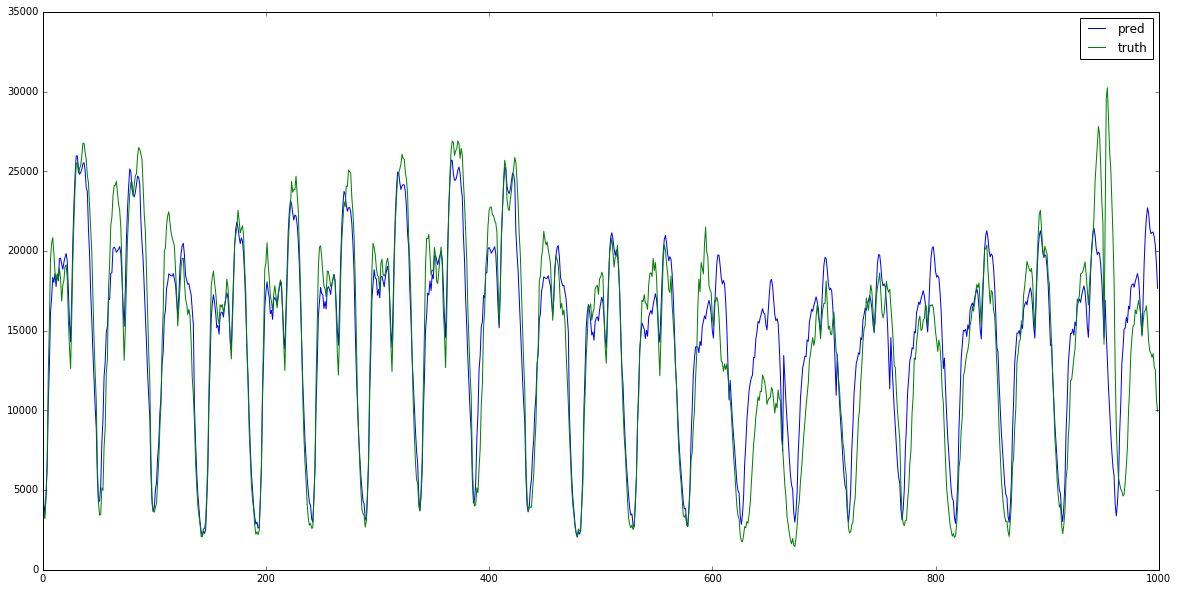

In [4]:
pred = model.predict(X_train)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

pred = scaler.inverse_transform(pred.reshape(-1,1))
truth = scaler.inverse_transform(Y_train.reshape(-1,1))
# pred = pred.flatten()
# truth = Y_test.flatten()

from sklearn import metrics

print metrics.explained_variance_score(truth,pred)
print metrics.r2_score(truth,pred)
print metrics.mean_absolute_error(truth,pred),truth.mean(),truth.std()

plt.plot(pred[-1000:],label='pred')
plt.plot(truth[-1000:],label='truth')
plt.legend()
plt.show()

In [5]:
# Use scikit-learn to grid search the batch size and epochs
from sklearn.grid_search import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

def create_model():
    model = Sequential()
    model.add(Activation('relu', input_shape=(INPUT_LEN,)))
    model.add(Dense(INPUT_LEN))
    model.add(Activation('linear', input_shape=(INPUT_LEN,)))
    model.add(Dense(INPUT_LEN/2, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
    model.add(Dropout(0.1))
    model.add(Activation('linear', input_shape=(INPUT_LEN/2,)))
    model.add(Dense(INPUT_LEN/4, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
    model.add(Dropout(0.1))
    model.add(Activation('linear', input_shape=(INPUT_LEN/4,)))
    model.add(Dense(OUTPUT_LEN))

    model.compile(loss='mse', optimizer='rmsprop')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
print 'get model'
# define the grid search parameters
batch_size = [40, 60, 80, 100]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, nb_epoch=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=1)
grid_result = grid.fit(X_train, Y_train)
print 'fit done'
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

get model
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  3.2min finished


fit done
Best: 0.111311 using {'nb_epoch': 50, 'batch_size': 60}
0.109228 (0.042799) with: {'nb_epoch': 50, 'batch_size': 40}
0.093604 (0.028156) with: {'nb_epoch': 100, 'batch_size': 40}
0.111366 (0.038815) with: {'nb_epoch': 50, 'batch_size': 60}
0.081291 (0.028611) with: {'nb_epoch': 100, 'batch_size': 60}
0.100747 (0.042150) with: {'nb_epoch': 50, 'batch_size': 80}
0.069377 (0.021567) with: {'nb_epoch': 100, 'batch_size': 80}
0.107539 (0.030534) with: {'nb_epoch': 50, 'batch_size': 100}
0.075115 (0.020579) with: {'nb_epoch': 100, 'batch_size': 100}
